In [1]:
from pycoral.pybind._pywrap_coral import GetRuntimeVersion as get_runtime_version
from pycoral.pybind._pywrap_coral import ListEdgeTpus as list_edge_tpus
print('runtime', get_runtime_version())
print('edge tpus', list_edge_tpus())

runtime BuildLabel(COMPILER=6.3.0 20170516,DATE=redacted,TIME=redacted), RuntimeVersion(14)
edge tpus [{'type': 'pci', 'path': '/dev/apex_0'}]


In [2]:
import time
import json
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pycoral.adapters import classify
from pycoral.adapters import common
from pycoral.utils.dataset import read_label_file
from pycoral.utils.edgetpu import make_interpreter

# load labels and model
model can be created in colab (convert tflite and edge-tpu)

In [3]:
labels_file = './models/imagenet_labels.json'
model_file_name = './models/mobilenet_v2_tf2.6.0_edgetpu.tflite'

with open(labels_file) as json_file:
    json_data = json.load(json_file)
    
labels = {int(key): value for key, value in json_data.items()}
print(len(labels), 'labels found')

interpreter = make_interpreter(*model_file_name.split('@'))
interpreter.allocate_tensors()
# Model must be uint8 quantized
if common.input_details(interpreter, 'dtype') != np.uint8:
    raise ValueError('Only support uint8 input type.')

size = common.input_size(interpreter)
# print('size', size)

1000 labels found


# proprocess function

In [4]:
def preprocess_image(image):
    image = image.convert('RGB').resize(size, Image.ANTIALIAS)
    params = common.input_details(interpreter, 'quantization_parameters')
    scale = params['scales']
    zero_point = params['zero_points']
    mean = 128.0
    std = 128.0
    if abs(scale * std - 1) < 1e-5 and abs(mean - zero_point) < 1e-5:
          # Input data does not require preprocessing.
        common.set_input(interpreter, image)
    else:
        # Input data requires preprocessing
        normalized_input = (np.asarray(image) - mean) / (std * scale) + zero_point
        np.clip(normalized_input, 0, 255, out=normalized_input)
        common.set_input(interpreter, normalized_input.astype(np.uint8))

# test with one image

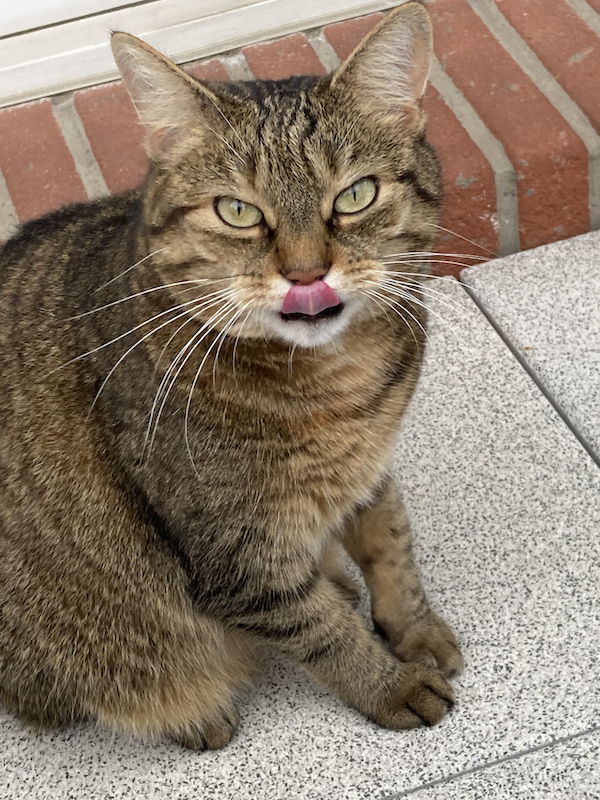

In [6]:
Image.open("./images/cat.jpg")

In [8]:
# efficiency; we use 1e-5 below instead of absolute zero).
image = preprocess_image(Image.open("./images/cat.jpg"))
top_k = 5
threshold = 0.0

# Run inference
print('----INFERENCE TIME----')
print('Note: The first inference on Edge TPU is slow because it includes',
      'loading the model into Edge TPU memory.')
for _ in range(5):
  start = time.perf_counter()
  interpreter.invoke()
  inference_time = time.perf_counter() - start
  classes = classify.get_classes(interpreter, top_k, threshold)
  print('%.1fms' % (inference_time * 1000))

print('-------RESULTS--------')
for c in classes:
  print('%s: %.5f' % (labels.get(c.id, c.id), c.score))



----INFERENCE TIME----
Note: The first inference on Edge TPU is slow because it includes loading the model into Edge TPU memory.
18.1ms
3.5ms
3.5ms
3.5ms
3.6ms
-------RESULTS--------
tabby, tabby cat: 0.52344
tiger cat: 0.07812
laptop, laptop computer: 0.02344
doormat, welcome mat: 0.01953
Egyptian cat: 0.01953


# test with images from internet

In [19]:
image_urls = [
    'https://github.com/nico-klein/coral/raw/main/images/cat2.jpg',
    'https://github.com/nico-klein/coral/raw/main/images/cup.jpg',
    'https://github.com/nico-klein/coral/raw/main/images/pizza.jpg',
    'https://github.com/nico-klein/coral/raw/main/images/spider.jpg',
    'https://github.com/nico-klein/coral/raw/main/images/car.jpg']
  
top_k = 1
threshold = 0.0


preprocess: 66.3ms inference: 4.0ms
preprocess: 58.7ms inference: 3.5ms
preprocess: 62.6ms inference: 4.5ms
preprocess: 60.0ms inference: 3.5ms
preprocess: 63.9ms inference: 4.5ms


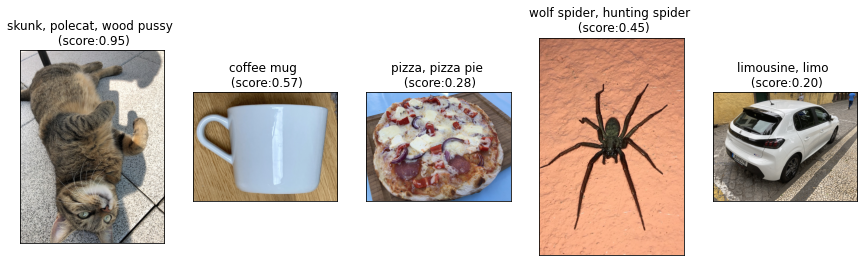

In [26]:
fig = plt.figure(figsize=(15, 10))
for i, url in enumerate(image_urls):
    # load image
    response = requests.get(url)
    if response.status_code < 299:
        start = time.perf_counter()
        raw_image = Image.open(io.BytesIO(response.content))
        image = preprocess_image(raw_image)
        preprocess_time = time.perf_counter() - start
        start = time.perf_counter()
        interpreter.invoke()
        class_top = classify.get_classes(interpreter, top_k, threshold)[0]
        inference_time = time.perf_counter() - start
        print(f'preprocess: {preprocess_time * 1000:.1f}ms inference: {inference_time * 1000:.1f}ms')
        #for c in classes:
        #    print('%s: %.5f' % (labels.get(c.id, c.id), c.score))
        pred_label = f'{labels.get(class_top.id, class_top.id)} \n (score:{class_top.score:.2f})' 

        #df, duration_predict = predict_from_image_array(img_array)
        #pred_label = df.nlargest(1, 'proba')[['label','proba']].values[0][0].split(',')[0]
        #pred_proba = df.nlargest(1, 'proba')[['label','proba']].values[0][1]

        # draw image
        ax = fig.add_subplot(1, len(image_urls), i + 1)
        plt.imshow(raw_image)
        ax.set_title(pred_label)
        ax.set_xticks([])
        ax.set_yticks([])
        #print(f'{pred_label} \t time prepr./pred.:{duration_preprocess:0.2f}s/{duration_predict:0.2f}s image size {img.size}')
    else:
        print(f'not found ({response.status_code}): "{url}"')